In [1]:
# Basic math/stats
import os
import math
import numpy as np
import pandas as pd
from scipy import stats

# Scikit-Learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch
import torch
import gpytorch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [2]:
# Create PyTorch Dataset
class HousingDataset(Dataset):
  def __init__(self, features, targets):
    self.features = torch.tensor(features, dtype=torch.float32)
    self.targets = torch.tensor(targets, dtype=torch.float32)
    self.n_samples = features.shape[0]

  def __getitem__(self, index):
    return self.features[index], self.targets[index]

  def __len__(self):
    return self.n_samples

# Define KISS-GP Model
class GPRegressionModel(gpytorch.models.ExactGP, nn.Module):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(), grid_size=grid_size, num_dims=2
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class GPRegressionModel_MixedKernel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel_MixedKernel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel() + gpytorch.kernels.LinearKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
'''
# Define KISS-GP Model
class GPRegressionModel(gpytorch.models.ExactGP, nn.Module):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.MaternKernel(), grid_size=grid_size, num_dims=1
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
'''
# Define training function
def train():
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

        training_loss_vec.append(loss.item())

        print(f'Iteration {i}, Loss: {loss.item()}')

In [3]:
# Get the dataset csv file
df_raw = pd.read_csv('dataset.csv')

# Drop 'id'
df_clean = df_raw.drop(['id'], axis=1)

# Replace 'yr_renovated' with 'renovated' Boolean
df_clean['renovated'] = (df_clean["yr_renovated"] != 0).astype(int)
df_clean = df_clean.drop(['yr_renovated'], axis=1)

# Replace complex 'date' with 'yr_sold' (year of sale)
df_clean['yr_sold'] = [int(df_clean['date'][i][:4]) for i in range(len(df_clean))]
df_clean = df_clean.drop(['date'], axis=1)

# Split into training/testing sets
df_train_unscaled, df_test_unscaled = train_test_split(df_clean, test_size=0.6, random_state=0)

# Scale datasets
scaler = StandardScaler()
scaled_train_values = scaler.fit_transform(df_train_unscaled)
scaled_test_values = scaler.transform(df_test_unscaled)

## HERE
price_scaler = StandardScaler()
price_scaler.fit(np.array(df_train_unscaled['price']).reshape([-1,1]))

sqft_living_scaler = StandardScaler()
sqft_living_scaler.fit(np.array(df_train_unscaled['sqft_living']).reshape([-1,1]))

grade_scaler = StandardScaler()
grade_scaler.fit(np.array(df_train_unscaled['grade']).reshape([-1,1]))

df_train = pd.DataFrame(scaled_train_values, columns=df_clean.columns)
df_test = pd.DataFrame(scaled_test_values, columns=df_clean.columns)

#### EXPERIMENTAL ####
# Remove outliers from training set
df_train = df_train[(np.abs(stats.zscore(df_train)) < 3).all(axis=1)]
#### EXPERIMENTAL ####

# Set training features and targets
train_features = df_train[['sqft_living', 'grade']].values
train_targets = df_train['price'].values

# Set testing features and targets (these should match above)
test_features = df_test[['sqft_living', 'grade']].values
test_targets = df_test['price'].values

# Transform the dataset to PyTorch Class
train_dataset = HousingDataset(train_features, train_targets)
test_dataset = HousingDataset(test_features, test_targets)

# Transform training/testing sets to PyTorch tensors
train_x = train_dataset.features
train_y = train_dataset.targets
test_x = test_dataset.features
test_y = test_dataset.targets

# For future visualizations
##x_visual = torch.tensor(np.linspace(float(train_x.min()), float(train_x.max()), 1000).reshape([-1,1]))

# FOR VISUALIZATIONS, MUST UPDATE TO INCLUDE 2D DATA
'''
x_visual = torch.tensor(np.linspace(float(min(train_x.min(), test_x.min())),
                         float(max(train_x.max(), test_x.max())),
                               1000).reshape([-1,1]))
'''

'\nx_visual = torch.tensor(np.linspace(float(min(train_x.min(), test_x.min())),\n                         float(max(train_x.max(), test_x.max())),\n                               1000).reshape([-1,1]))\n'

In [5]:
# PERFORM BASIC LINEAR REGRESSION

LR_model = LinearRegression()
LR_model.fit(train_x, train_y)

train_LR_mean_scaled = LR_model.predict(train_x)
test_LR_mean_scaled = LR_model.predict(test_x)

train_LR_mean = price_scaler.inverse_transform(np.array(train_LR_mean_scaled).reshape([-1,1]))
test_LR_mean = price_scaler.inverse_transform(np.array(test_LR_mean_scaled).reshape([-1,1]))

# Acquire predictions on the "visual" set for LR
##LR_visual_mean = LR_model.predict(x_visual)

In [6]:
# PERFORM KISS-GP (SKI) REGRESSION

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50

# Define the likelihood and model here
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# To hold training losses
training_loss_vec = []

# Train the model
%time train()

# Set model and likelihood into evaluation mode
model.eval()
likelihood.eval()

# Acquire predictions on the testing set
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(test_x))
    test_SKI_mean_scaled = prediction.mean
    test_SKI_var_scaled = prediction.variance

# Acquire predictions on the test set
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(train_x))
    train_SKI_mean_scaled = prediction.mean
    train_SKI_var_scaled = prediction.variance

# Unscale the predictions (back to $ values)
train_SKI_mean = price_scaler.inverse_transform(np.array(train_SKI_mean_scaled).reshape([-1,1]))
test_SKI_mean = price_scaler.inverse_transform(np.array(test_SKI_mean_scaled).reshape([-1,1]))

'''
# Acquire predictions on the "visual" set for KISS-GP SKI
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(x_visual.to(torch.float32)))
    SKI_visual_mean = prediction.mean
    SKI_visual_var = prediction.variance
'''

/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/sparse.py:66: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:644.)
  res = cls(index_tensor, value_tensor, interp_size)


Iteration 0, Loss: 0.8962664008140564
Iteration 1, Loss: 0.8837406039237976
Iteration 2, Loss: 0.8701353669166565
Iteration 3, Loss: 0.8583170771598816
Iteration 4, Loss: 0.8456243276596069
Iteration 5, Loss: 0.8328837752342224
Iteration 6, Loss: 0.821313738822937
Iteration 7, Loss: 0.8093404769897461
Iteration 8, Loss: 0.7975192666053772
Iteration 9, Loss: 0.7859629988670349
Iteration 10, Loss: 0.7746714353561401
Iteration 11, Loss: 0.7631673216819763
Iteration 12, Loss: 0.752940833568573
Iteration 13, Loss: 0.7425527572631836
Iteration 14, Loss: 0.732862114906311
Iteration 15, Loss: 0.7237696647644043
Iteration 16, Loss: 0.7143356204032898
Iteration 17, Loss: 0.7057506442070007
Iteration 18, Loss: 0.697508692741394
Iteration 19, Loss: 0.6901008486747742
Iteration 20, Loss: 0.6832873225212097
Iteration 21, Loss: 0.6770130395889282
Iteration 22, Loss: 0.6710324287414551
Iteration 23, Loss: 0.666068434715271
Iteration 24, Loss: 0.661312997341156
Iteration 25, Loss: 0.6572964787483215
It

/home/dave/ml/my_env/lib/python3.11/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
/home/dave/ml/my_env/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/home/dave/ml/my_env/lib/python3.11/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


'\n# Acquire predictions on the "visual" set for KISS-GP SKI\nwith torch.no_grad(), gpytorch.settings.fast_pred_var():\n    prediction = likelihood(model(x_visual.to(torch.float32)))\n    SKI_visual_mean = prediction.mean\n    SKI_visual_var = prediction.variance\n'

In [7]:
# PERFORM STANDARD GP WITH MIXED KERNEL

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50

# Define the likelihood and model here
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel_MixedKernel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# To hold training losses
training_loss_vec = []

# Train the model
%time train()

# Set model and likelihood into evaluation mode
model.eval()
likelihood.eval()

# Acquire predictions on the testing set
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(test_x))
    test_EGP_mean_scaled = prediction.mean
    test_EGP_var_scaled = prediction.variance

# Acquire predictions on the test set
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(train_x))
    train_EGP_mean_scaled = prediction.mean
    train_EGP_var_scaled = prediction.variance

# Unscale the predictions (back to $ values)
train_EGP_mean = price_scaler.inverse_transform(np.array(train_EGP_mean_scaled).reshape([-1,1]))
test_EGP_mean = price_scaler.inverse_transform(np.array(test_EGP_mean_scaled).reshape([-1,1]))

'''
# Acquire predictions on the "visual" set for ExactGP (Mixed Kernel)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(x_visual.to(torch.float32)))
    EGP_visual_mean = prediction.mean
    EGP_visual_var = prediction.variance
'''

Iteration 0, Loss: 0.8953746557235718
Iteration 1, Loss: 0.8826320171356201
Iteration 2, Loss: 0.8698049187660217
Iteration 3, Loss: 0.8575753569602966
Iteration 4, Loss: 0.844968855381012
Iteration 5, Loss: 0.8331571817398071
Iteration 6, Loss: 0.8207027912139893
Iteration 7, Loss: 0.8089107275009155
Iteration 8, Loss: 0.7969045639038086
Iteration 9, Loss: 0.7855183482170105
Iteration 10, Loss: 0.7748382091522217
Iteration 11, Loss: 0.7634917497634888
Iteration 12, Loss: 0.7526942491531372
Iteration 13, Loss: 0.7420443892478943
Iteration 14, Loss: 0.7324540019035339
Iteration 15, Loss: 0.7226917147636414
Iteration 16, Loss: 0.7138871550559998
Iteration 17, Loss: 0.705342173576355
Iteration 18, Loss: 0.6971932649612427
Iteration 19, Loss: 0.6897997856140137
Iteration 20, Loss: 0.6826820969581604
Iteration 21, Loss: 0.676445484161377
Iteration 22, Loss: 0.6703956723213196
Iteration 23, Loss: 0.6653807163238525
Iteration 24, Loss: 0.6606304049491882
Iteration 25, Loss: 0.656791627407074


/home/dave/ml/my_env/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


'\n# Acquire predictions on the "visual" set for ExactGP (Mixed Kernel)\nwith torch.no_grad(), gpytorch.settings.fast_pred_var():\n    prediction = likelihood(model(x_visual.to(torch.float32)))\n    EGP_visual_mean = prediction.mean\n    EGP_visual_var = prediction.variance\n'

In [8]:
# PERFORM RESIDUAL GP REGRESSION

basis_model = LinearRegression()
basis_model.fit(train_x, train_y)

basis_y = basis_model.predict(train_x)

# True - Prediction
res_train_x = train_y - basis_y

train_LR_mean = price_scaler.inverse_transform(np.array(train_LR_mean_scaled).reshape([-1,1]))
test_LR_mean = price_scaler.inverse_transform(np.array(test_LR_mean_scaled).reshape([-1,1]))

'''
# Acquire predictions on the "visual" set for LR
LR_visual_mean = LR_model.predict(x_visual)
'''

'\n# Acquire predictions on the "visual" set for LR\nLR_visual_mean = LR_model.predict(x_visual)\n'

In [9]:
basis_model = LinearRegression()
basis_model.fit(train_x, train_y)

basis_y_train = basis_model.predict(train_x)
basis_y_test = basis_model.predict(test_x)

'''
basis_y_visual = basis_model.predict(x_visual)
'''

# True - Prediction = Residuals
res_train_x = train_y - basis_y_train

# ======== Fit KISS-GP (SKI) on the residuals ======== #

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50

# Define the likelihood and model here
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, res_train_x, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# To hold training losses
training_loss_vec = []

# Train the model
%time train()

# Set model and likelihood into evaluation mode
model.eval()
likelihood.eval()

# Acquire predictions on the testing set
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(test_x))
    test_ADD_mean_scaled = prediction.mean
    test_ADD_var_scaled = prediction.variance

test_ADD_mean_scaled = test_ADD_mean_scaled + basis_y_test

# Acquire predictions on the test set
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(train_x))
    train_ADD_mean_scaled = prediction.mean
    train_ADD_var_scaled = prediction.variance

train_ADD_mean_scaled = train_ADD_mean_scaled + basis_y_train

# Unscale the predictions (back to $ values)
train_ADD_mean = price_scaler.inverse_transform(np.array(train_ADD_mean_scaled).reshape([-1,1]))
test_ADD_mean = price_scaler.inverse_transform(np.array(test_ADD_mean_scaled).reshape([-1,1]))

'''
# Acquire predictions on the "visual" set for KISS-GP SKI
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(x_visual.to(torch.float32)))
    ADD_visual_mean = prediction.mean
    ADD_visual_var = prediction.variance

ADD_visual_mean = ADD_visual_mean + basis_y_visual
'''

Iteration 0, Loss: 0.8956857919692993
Iteration 1, Loss: 0.8829383850097656
Iteration 2, Loss: 0.8709267973899841
Iteration 3, Loss: 0.8574616312980652
Iteration 4, Loss: 0.8459364771842957
Iteration 5, Loss: 0.8333815336227417
Iteration 6, Loss: 0.8207548260688782
Iteration 7, Loss: 0.809171199798584
Iteration 8, Loss: 0.797320544719696
Iteration 9, Loss: 0.7861008048057556
Iteration 10, Loss: 0.7748555541038513
Iteration 11, Loss: 0.7634504437446594
Iteration 12, Loss: 0.7530630826950073
Iteration 13, Loss: 0.7423310875892639
Iteration 14, Loss: 0.7326796054840088
Iteration 15, Loss: 0.7233672142028809
Iteration 16, Loss: 0.7141593098640442
Iteration 17, Loss: 0.7056887745857239
Iteration 18, Loss: 0.6978185772895813
Iteration 19, Loss: 0.6900964379310608
Iteration 20, Loss: 0.6831186413764954
Iteration 21, Loss: 0.6768035888671875
Iteration 22, Loss: 0.6710503697395325
Iteration 23, Loss: 0.6660849452018738
Iteration 24, Loss: 0.6613818407058716
Iteration 25, Loss: 0.657264888286590

/home/dave/ml/my_env/lib/python3.11/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
/home/dave/ml/my_env/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/home/dave/ml/my_env/lib/python3.11/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


'\n# Acquire predictions on the "visual" set for KISS-GP SKI\nwith torch.no_grad(), gpytorch.settings.fast_pred_var():\n    prediction = likelihood(model(x_visual.to(torch.float32)))\n    ADD_visual_mean = prediction.mean\n    ADD_visual_var = prediction.variance\n\nADD_visual_mean = ADD_visual_mean + basis_y_visual\n'

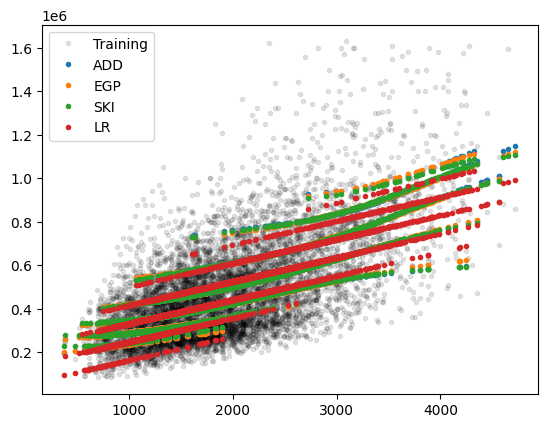

In [16]:
plt.plot(sqft_living_scaler.inverse_transform(np.array(train_x[:,0]).reshape([-1,1])),
         price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), 'k.', alpha=0.1, label='Training')
plt.plot(sqft_living_scaler.inverse_transform(np.array(train_x[:,0]).reshape([-1,1])), train_ADD_mean, '.', label='ADD')
plt.plot(sqft_living_scaler.inverse_transform(np.array(train_x[:,0]).reshape([-1,1])), train_EGP_mean, '.', label='EGP')
plt.plot(sqft_living_scaler.inverse_transform(np.array(train_x[:,0]).reshape([-1,1])), train_SKI_mean, '.', label='SKI')
plt.plot(sqft_living_scaler.inverse_transform(np.array(train_x[:,0]).reshape([-1,1])), train_LR_mean, '.', label='LR')
plt.legend()

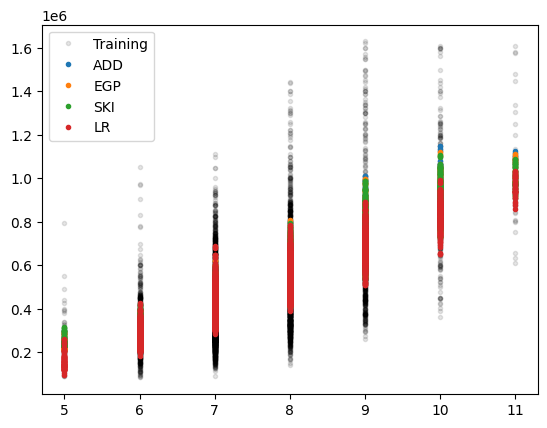

In [22]:
plt.plot(grade_scaler.inverse_transform(np.array(train_x[:,1]).reshape([-1,1])),
         price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), 'k.', alpha=0.1, label='Training')
plt.plot(grade_scaler.inverse_transform(np.array(train_x[:,1]).reshape([-1,1])), train_ADD_mean, '.', label='ADD')
plt.plot(grade_scaler.inverse_transform(np.array(train_x[:,1]).reshape([-1,1])), train_EGP_mean, '.', label='EGP')
plt.plot(grade_scaler.inverse_transform(np.array(train_x[:,1]).reshape([-1,1])), train_SKI_mean, '.', label='SKI')
plt.plot(grade_scaler.inverse_transform(np.array(train_x[:,1]).reshape([-1,1])), train_LR_mean, '.', label='LR')
plt.legend()

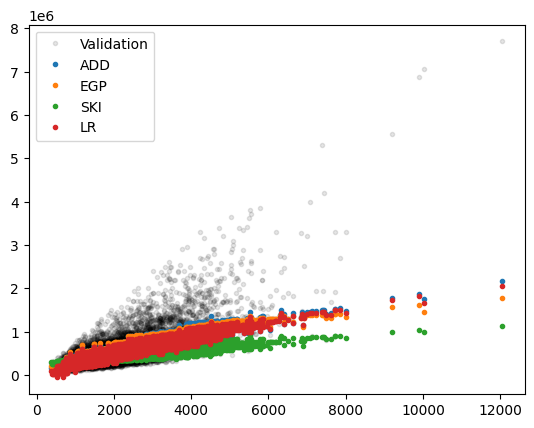

In [17]:
plt.plot(sqft_living_scaler.inverse_transform(np.array(test_x[:,0]).reshape([-1,1])),
         price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), 'k.', alpha=0.1, label='Validation')
plt.plot(sqft_living_scaler.inverse_transform(np.array(test_x[:,0]).reshape([-1,1])), test_ADD_mean, '.', label='ADD')
plt.plot(sqft_living_scaler.inverse_transform(np.array(test_x[:,0]).reshape([-1,1])), test_EGP_mean, '.', label='EGP')
plt.plot(sqft_living_scaler.inverse_transform(np.array(test_x[:,0]).reshape([-1,1])), test_SKI_mean, '.', label='SKI')
plt.plot(sqft_living_scaler.inverse_transform(np.array(test_x[:,0]).reshape([-1,1])), test_LR_mean, '.', label='LR')
plt.legend()

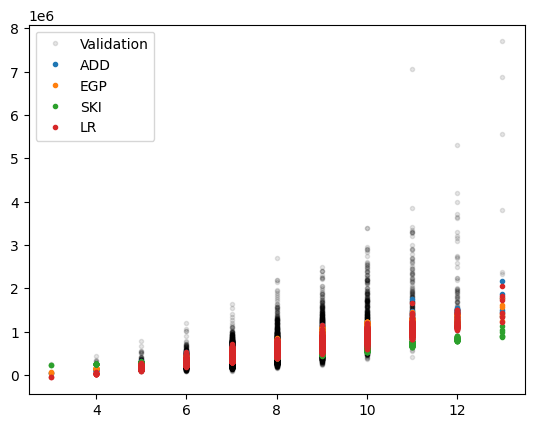

In [21]:
plt.plot(grade_scaler.inverse_transform(np.array(test_x[:,1]).reshape([-1,1])),
         price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), 'k.', alpha=0.1, label='Validation')
plt.plot(grade_scaler.inverse_transform(np.array(test_x[:,1]).reshape([-1,1])), test_ADD_mean, '.', label='ADD')
plt.plot(grade_scaler.inverse_transform(np.array(test_x[:,1]).reshape([-1,1])), test_EGP_mean, '.', label='EGP')
plt.plot(grade_scaler.inverse_transform(np.array(test_x[:,1]).reshape([-1,1])), test_SKI_mean, '.', label='SKI')
plt.plot(grade_scaler.inverse_transform(np.array(test_x[:,1]).reshape([-1,1])), test_LR_mean, '.', label='LR')
plt.legend()

In [18]:
print('Linear Regression MAE:', mean_absolute_error(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), test_LR_mean))
print('KISS-GP (SKI) MAE:', mean_absolute_error(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), test_SKI_mean))
print('ExactGP Mixture MAE: ', mean_absolute_error(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), test_EGP_mean))
print('Residual Model MAE: ', mean_absolute_error(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), test_ADD_mean))
print('\n')

print('Linear Regression MSE:', mean_squared_error(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), test_LR_mean))
print('KISS-GP (SKI) MSE:', mean_squared_error(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), test_SKI_mean))
print('ExactGP Mixture MSE: ', mean_squared_error(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), test_EGP_mean))
print('Residual Model MSE: ', mean_squared_error(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), test_ADD_mean))
print('\n')

print('Linear Regression Median Absolute Error:', np.median(np.abs(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])) - test_LR_mean)))
print('KISS-GP (SKI) Median Absolute Error:', np.median(np.abs(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])) - test_SKI_mean)))
print('ExactGP Mixture Median Absolute Error:', np.median(np.abs(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])) - test_EGP_mean)))
print('Residual Model Median Absolute Error:', np.median(np.abs(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])) - test_ADD_mean)))

Linear Regression MAE: 155678.72
KISS-GP (SKI) MAE: 189774.61
ExactGP Mixture MAE:  153338.16
Residual Model MAE:  155568.78


Linear Regression MSE: 71443000000.0
KISS-GP (SKI) MSE: 111660425000.0
ExactGP Mixture MSE:  68751335000.0
Residual Model MSE:  69307350000.0


Linear Regression Median Absolute Error: 107915.266
KISS-GP (SKI) Median Absolute Error: 116308.266
ExactGP Mixture Median Absolute Error: 107945.0
Residual Model Median Absolute Error: 112131.55


In [23]:
print('Linear Regression MAE:', mean_absolute_error(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), train_LR_mean))
print('KISS-GP (SKI) MAE:', mean_absolute_error(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), train_SKI_mean))
print('ExactGP Mixture MAE: ', mean_absolute_error(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), train_EGP_mean))
print('Residual Model MAE: ', mean_absolute_error(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), train_ADD_mean))
print('\n')

print('Linear Regression MSE:', mean_squared_error(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), train_LR_mean))
print('KISS-GP (SKI) MSE:', mean_squared_error(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), train_SKI_mean))
print('ExactGP Mixture MSE: ', mean_squared_error(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), train_EGP_mean))
print('Residual Model MSE: ', mean_squared_error(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), train_ADD_mean))
print('\n')

print('Linear Regression Median Absolute Error:', np.median(np.abs(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])) - train_LR_mean)))
print('KISS-GP (SKI) Median Absolute Error:', np.median(np.abs(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])) - train_SKI_mean)))
print('ExactGP Mixture Median Absolute Error:', np.median(np.abs(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])) - train_EGP_mean)))
print('Residual Model Median Absolute Error:', np.median(np.abs(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])) - train_ADD_mean)))

Linear Regression MAE: 128169.47
KISS-GP (SKI) MAE: 126717.6
ExactGP Mixture MAE:  126761.69
Residual Model MAE:  126722.04


Linear Regression MSE: 28684315000.0
KISS-GP (SKI) MSE: 27973499000.0
ExactGP Mixture MSE:  27984430000.0
Residual Model MSE:  27963202000.0


Linear Regression Median Absolute Error: 105767.03
KISS-GP (SKI) Median Absolute Error: 104302.06
ExactGP Mixture Median Absolute Error: 104581.0
Residual Model Median Absolute Error: 104445.875
